#TP04 - QA Bot basado

El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).

## 1 - Cargamos de los datos y las librerias

In [75]:
!pip install keras
!pip install --upgrade --no-cache-dir gdown --quiet
!pip install fasttext
!pip install --upgrade tensorflow

import pandas as pd
import numpy as np
import tensorflow as tf
import fasttext
import fasttext.util
import string
import os
import gdown

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Activation, Dropout, Dense, Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input
from sklearn.model_selection import train_test_split

Este dataset aborda el desafío de responder automáticamente a preguntas generadas a partir de texto de artículos de Wikipedia. Incluye tres archivos de preguntas (S08, S09, S10) con preguntas, respuestas, y niveles de dificultad. El texto de Wikipedia usado contiene 690,000 palabras. El dataset fue recopilado por investigadores de Carnegie Mellon y la Universidad de Pittsburgh entre 2008 y 2010.

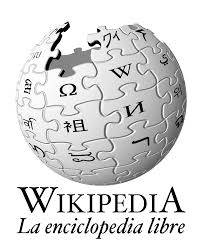

In [76]:
# URLs de los archivos en Google Drive
urls = [
    'https://drive.google.com/uc?id=1ibDp-rfVGaUdBXfw6Rbkvr2H8FQBi-tW',
    'https://drive.google.com/uc?id=1x7WRCBXY-ZhDZI4D9EKyZytNpOJwS2nt',
    'https://drive.google.com/uc?id=1FZUtXLRMTvb8p2U2VneLFyzHI1xWI37f'
]

# Descargar los archivos
for url in urls:
    gdown.download(url, quiet=False)

# Cargar los archivos en DataFrames
d1 = pd.read_csv('S08_question_answer_pairs.txt', sep='\t')
d2 = pd.read_csv('S09_question_answer_pairs.txt', sep='\t')
d3 = pd.read_csv('S10_question_answer_pairs.txt', sep='\t', encoding='ISO-8859-1')

# Concatenar los DataFrames
dat2 = pd.concat([d1, d2, d3], ignore_index=True)

# Asegurarse de que todos los valores sean cadenas
dat2['Question'] = dat2['Question'].astype(str)
dat2['Answer'] = dat2['Answer'].astype(str)

# Crear la columna 'Question' combinando 'ArticleTitle' y 'Question'
dat2['Question'] = dat2['ArticleTitle'].str.replace('_', ' ') + ' ' + dat2['Question']

# Seleccionar las columnas necesarias y eliminar duplicados
dat2 = dat2[['Question', 'Answer']]
dat2 = dat2.drop_duplicates(subset='Question')

# Convertir dat2 a una estructura con entradas independientes para preguntas y respuestas
def convert_to_format(dat2):
    converted_data = []
    for i in range(len(dat2)):
        question_text = str(dat2.iloc[i]['Question'])
        answer_text = str(dat2.iloc[i]['Answer'])

        # Validar que los textos sean cadenas antes de añadirlos
        if not isinstance(question_text, str):
            raise TypeError("Question text must be a string.")
        if not isinstance(answer_text, str):
            raise TypeError("Answer text must be a string.")

        # Crear las entradas para pregunta y respuesta
        entry_question = {
            'text': question_text,
            'type': 'Question'
        }
        entry_answer = {
            'text': answer_text,
            'type': 'Answer'
        }

        # Añadir los dos mensajes por separado
        converted_data.append(entry_question)
        converted_data.append(entry_answer)

    return converted_data

# Aplicar la conversión
data3 = convert_to_format(dat2)

# Verificar el resultado
print(data3[:2])  # Mostrar las primeras dos entradas para verificar


Downloading...
From: https://drive.google.com/uc?id=1ibDp-rfVGaUdBXfw6Rbkvr2H8FQBi-tW
To: /content/S08_question_answer_pairs.txt
100%|██████████| 181k/181k [00:00<00:00, 67.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x7WRCBXY-ZhDZI4D9EKyZytNpOJwS2nt
To: /content/S09_question_answer_pairs.txt
100%|██████████| 85.4k/85.4k [00:00<00:00, 52.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FZUtXLRMTvb8p2U2VneLFyzHI1xWI37f
To: /content/S10_question_answer_pairs.txt
100%|██████████| 166k/166k [00:00<00:00, 84.3MB/s]


[{'text': 'Abraham Lincoln Was Abraham Lincoln the sixteenth President of the United States?', 'type': 'Question'}, {'text': 'yes', 'type': 'Answer'}]


In [77]:
# Verificar el resultado
print(data3[:1])  # Mostrar las primeras dos entradas para verificar

[{'text': 'Abraham Lincoln Was Abraham Lincoln the sixteenth President of the United States?', 'type': 'Question'}]


In [80]:
import re

# Configuración
max_len = 30

# Función para limpiar el texto
def clean_text(txt):
    txt = txt.lower()
    txt = txt.replace("'d", " had")
    txt = txt.replace("'s", " is")
    txt = txt.replace("'m", " am")
    txt = txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    return txt

# Inicializar listas para almacenar las oraciones
input_sentences = []
output_sentences = []
output_sentences_inputs = []

# Convertir `dat2` a una lista de diccionarios con preguntas y respuestas
dat2_list = dat2.to_dict(orient='records')

for line in dat2_list:
    chat_in = clean_text(line['Question'])
    chat_out = clean_text(line['Answer'])

    if len(chat_in.split()) >= max_len or len(chat_out.split()) >= max_len:
        continue

    # Añadir la oración de entrada y salida
    input_sentences.append(chat_in)
    output_sentences.append(chat_out + ' ')
    output_sentences_inputs.append(' ' + chat_out)

print("Cantidad de rows utilizadas:", len(input_sentences))


Cantidad de rows utilizadas: 2416


In [81]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('abraham lincoln did lincoln sign the national banking act of 1863 ',
 'yes ',
 ' yes')

##2 - Preprocesamiento.

word2idx_inputs, max_input_len
word2idx_outputs, max_out_len, num_words_output
encoder_input_sequences, decoder_output_sequences, decoder_targets

In [82]:
# Tokenización de las secuencias de entrada
tokenizer_inputs = Tokenizer()
tokenizer_inputs.fit_on_texts(input_sentences)
input_sequences = tokenizer_inputs.texts_to_sequences(input_sentences)

# Longitud máxima de la secuencia de entrada
max_input_len = max(len(seq) for seq in input_sequences)
word2idx_inputs = tokenizer_inputs.word_index

# Tokenización de las secuencias de salida
tokenizer_outputs = Tokenizer()
tokenizer_outputs.fit_on_texts(output_sentences + output_sentences_inputs)
output_sequences = tokenizer_outputs.texts_to_sequences(output_sentences)
output_sequences_inputs = tokenizer_outputs.texts_to_sequences(output_sentences_inputs)

# Longitud máxima de la secuencia de salida
max_out_len = max(len(seq) for seq in output_sequences)
word2idx_outputs = tokenizer_outputs.word_index
num_words_output = len(word2idx_outputs) + 1

# Padding de las secuencias
encoder_input_sequences = pad_sequences(input_sequences, maxlen=max_input_len)
decoder_output_sequences = pad_sequences(output_sequences, maxlen=max_out_len)
decoder_targets = pad_sequences(output_sequences_inputs, maxlen=max_out_len)

# Resultados
print(f"max_input_len: {max_input_len}")
print(f"max_out_len: {max_out_len}")
print(f"word2idx_inputs: {len(word2idx_inputs)} palabras")
print(f"word2idx_outputs: {num_words_output} palabras")

max_input_len: 29
max_out_len: 29
word2idx_inputs: 4269 palabras
word2idx_outputs: 2784 palabras


##3 - Preparar los embeddings

Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [72]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2024-08-29 04:51:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-29 04:51:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-29 04:51:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [73]:
# Descargar los embeddings de Glove
embedding_dim = 100
embeddings_index = {}

with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Preparar la matriz de embeddings
num_words = len(word2idx_inputs) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word2idx_inputs.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Capa de Embedding
embedding_layer = Embedding(
    num_words,
    embedding_dim,
    weights=[embedding_matrix],
    #input_length=max_input_len,
    trainable=False
)

Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [84]:
# Definir el modelo
latent_dim = 64

# Encoder
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(x)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(num_words_output, latent_dim)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Definir el modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar el modelo
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape de los targets para la entrada en el modelo
decoder_targets_one_hot = np.zeros(
    (len(input_sentences), max_out_len, num_words_output),
    dtype='float32'
)

for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

# Entrenamiento
model.fit(
    [encoder_input_sequences, decoder_output_sequences],
    decoder_targets_one_hot,
    batch_size=32,
    epochs=10,
    validation_split=0.2
)


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.8149 - loss: 5.6879 - val_accuracy: 0.8352 - val_loss: 1.7594
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - accuracy: 0.8929 - loss: 1.1122 - val_accuracy: 0.8352 - val_loss: 1.2292
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.8939 - loss: 0.7588 - val_accuracy: 0.8352 - val_loss: 1.1328
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 252ms/step - accuracy: 0.8949 - loss: 0.6929 - val_accuracy: 0.8468 - val_loss: 1.0947
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.9096 - loss: 0.6332 - val_accuracy: 0.8549 - val_loss: 1.0739
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.9054 - loss: 0.6675 - val_accuracy: 0.8549 - val_loss: 1.0580
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.9116 - loss: 0.6090 - val_accuracy: 0.8549 - val_loss: 1.0433
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.9103 - loss: 0.6092 - val_accu

##4 - Entrenar al modelo

In [85]:
# Definir el modelo
latent_dim = 136

# Encoder
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(x)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(num_words_output, latent_dim)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Definir el modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar el modelo
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape de los targets para la entrada en el modelo
decoder_targets_one_hot = np.zeros(
    (len(input_sentences), max_out_len, num_words_output),
    dtype='float32'
)

for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

# Entrenamiento
model.fit(
    [encoder_input_sequences, decoder_output_sequences],
    decoder_targets_one_hot,
    batch_size=8,
    epochs=15,
    validation_split=0.2
)


Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.8513 - loss: 2.6920 - val_accuracy: 0.8352 - val_loss: 1.1415
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - accuracy: 0.9042 - loss: 0.6582 - val_accuracy: 0.8547 - val_loss: 1.0758
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.9136 - loss: 0.6047 - val_accuracy: 0.8549 - val_loss: 1.0552
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 35s 154ms/step - accuracy: 0.9166 - loss: 0.5674 - val_accuracy: 0.8564 - val_loss: 1.0311
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - accuracy: 0.9076 - loss: 0.6191 - val_accuracy: 0.8579 - val_loss: 1.0042
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - accuracy: 0.9153 - loss: 0.5719 - val_accuracy: 0.8611 - val_loss: 0.9877
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.9166 - loss: 0.5765 - val_accuracy: 0.8642 - val_loss: 0.9785
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - accuracy: 0.9203 - loss: 0

##5 - Inferencia

In [90]:
# Modelo encoder
encoder_model = Model(encoder_inputs, encoder_states)

# Modelo decoder
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_x, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_lstm_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

# Función de predicción
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    # Check if 'start' exists in word2idx_outputs, if not, handle accordingly
    if 'start' in word2idx_outputs:
        target_seq[0, 0] = word2idx_outputs['start']
    else:
        # Use 'comienzo' as the SOS token
        if 'comienzo' in word2idx_outputs:
            target_seq[0, 0] = word2idx_outputs['comienzo']
        else:
            # Handle the case where 'comienzo' is not in word2idx_outputs
            print("Error: 'comienzo' no se encuentra en el diccionario.")
            # Puedes retornar un valor por defecto o manejar el error de otra manera

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Adjust index to account for starting at 1
        sampled_token_index = sampled_token_index + 1
        sampled_word = tokenizer_outputs.index_word[sampled_token_index]
        decoded_sentence += ' ' + sampled_word


        if sampled_word == 'end' or len(decoded_sentence) > max_out_len:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence

# Prueba del modelo
test_sentence = encoder_input_sequences[0:1]
translated_sentence = decode_sequence(test_sentence)
print(f"Input: {input_sentences[0]}")
print(f"Output: {translated_sentence}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Error: 'comienzo' no se encuentra en el diccionario.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Input: abraham lincoln was abraham lincoln the sixteenth president of the united states 
Output:  yes the nan of and was to was


#Bot QA 🤖
Construir QA Bot basado en el ejemplo del traductor pero con un dataset QA.

* MAX_VOCAB_SIZE = 8000
* max_length ~ 10
* Embeddings 300 Fasttext
* n_units = 128
* LSTM Dropout 0.2
* Epochs 30~50

## 1. Preparación de los Embeddings con FastText

In [91]:
# Descargar y cargar el modelo de FastText
fasttext.util.download_model('en', if_exists='ignore')  # modelo en inglés
ft = fasttext.load_model('cc.en.300.bin')

# Parámetros
MAX_VOCAB_SIZE = 8000
embedding_dim = 300

# Tokenización de las secuencias de entrada
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_inputs.fit_on_texts(input_sentences)
input_sequences = tokenizer_inputs.texts_to_sequences(input_sentences)
word2idx_inputs = tokenizer_inputs.word_index
max_input_len = min(max(len(seq) for seq in input_sequences), 10)

# Limitar el vocabulario a MAX_VOCAB_SIZE
num_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)

# Crear la matriz de embeddings
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word2idx_inputs.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = ft.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Capa de Embedding
embedding_layer = Embedding(
    num_words,
    embedding_dim,
    weights=[embedding_matrix],
    input_length=max_input_len,
    trainable=False
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## 2. Configuración del Modelo Encoder-Decoder

In [92]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

latent_dim = 128  # Tamaño de las unidades LSTM
max_out_len = 10  # Longitud máxima de las secuencias de salida

# Encoder
encoder_inputs = Input(shape=(None,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder(x)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding_layer = Embedding(num_words, latent_dim)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo completo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar el modelo
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


3. Preparación de los Datos y Entrenamiento del Modelo

In [93]:
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

In [94]:
# Convertir secuencias de salida en one-hot encoding
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_outputs.fit_on_texts(output_sentences)
output_sequences = tokenizer_outputs.texts_to_sequences(output_sentences)
output_sequences_inputs = tokenizer_outputs.texts_to_sequences(output_sentences_inputs)
word2idx_outputs = tokenizer_outputs.word_index
num_words_output = len(word2idx_outputs) + 1  # El +1 es necesario para incluir el índice 0

# Padding de secuencias ANTES de generar one-hot encoding
# Esto asegura que todas las secuencias tengan la misma longitud
encoder_input_sequences = pad_sequences(input_sequences, maxlen=max_input_len)
decoder_output_sequences = pad_sequences(output_sequences, maxlen=max_out_len, padding='post') # Asegurar que el padding sea 'post'
decoder_targets = pad_sequences(output_sequences_inputs, maxlen=max_out_len, padding='post') # Asegurar que el padding sea 'post'

# Convertir secuencias de salida en one-hot encoding DESPUÉS del padding
decoder_targets_one_hot = np.zeros(
    (len(input_sequences), max_out_len, num_words_output),
    dtype='float32'
)

for i, d in enumerate(decoder_targets): # Usar 'decoder_targets' que ya tienen padding
    for t, word in enumerate(d):
        if word < num_words_output: # Make sure word index is within bounds
            decoder_targets_one_hot[i, t, word] = 1

# Ensure the model is compiled only once, before training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
model.fit(
    [encoder_input_sequences, decoder_output_sequences],
    decoder_targets_one_hot,
    batch_size=64,
    epochs=30,  # Ajustable entre 30-50 epochs
    validation_split=0.2
)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6329 - loss: 5.9609 - val_accuracy: 0.6093 - val_loss: 3.1586
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 706ms/step - accuracy: 0.7366 - loss: 2.0223 - val_accuracy: 0.6093 - val_loss: 2.7638
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 746ms/step - accuracy: 0.7394 - loss: 1.7131 - val_accuracy: 0.6260 - val_loss: 2.6561
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 764ms/step - accuracy: 0.7498 - loss: 1.7077 - val_accuracy: 0.6413 - val_loss: 2.6048
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 853ms/step - accuracy: 0.7730 - loss: 1.5529 - val_accuracy: 0.6537 - val_loss: 2.5513
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - accuracy: 0.7788 - loss: 1.5083 - val_accuracy: 0.6564 - val_loss: 2.5237
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 373ms/step - accuracy: 0.7642 - loss: 1.5956 - val_accuracy: 0.6562 - val_loss: 2.5035
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.7625 - loss: 1.5784 - val_accurac

In [123]:
# Modelo encoder
encoder_model = Model(encoder_inputs, encoder_states)

# Modelo decoder
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_x, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_lstm_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

def decode_sequence(input_seq):
    # Obtener los estados del encoder
    states_value = encoder_model.predict(input_seq)

    # Inicializar la secuencia de entrada para el decoder con el token de inicio
    target_seq = np.zeros((1, 1))

    # Use the first value in word2idx_outputs if 'start' or 'comienzo' are not found
    start_token = word2idx_outputs.get('start', word2idx_outputs.get('comienzo', next(iter(word2idx_outputs.values()))))
    target_seq[0, 0] = start_token

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Obtener predicciones del modelo del decoder
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Obtener el índice de la palabra con la mayor probabilidad
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer_outputs.index_word.get(sampled_token_index, '')

        # Si no se encuentra una palabra, romper el bucle
        if sampled_word == '':
            print("Advertencia: índice de palabra desconocido. Interrumpiendo la decodificación.")
            break

        # Añadir la palabra decodificada a la oración
        decoded_sentence += ' ' + sampled_word

        # Condiciones de parada
        if (sampled_word == 'end') or (len(decoded_sentence.split()) >= max_out_len):
            stop_condition = True

        # Actualizar la secuencia de entrada para el próximo paso de decodificación
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Actualizar los estados internos del LSTM
        states_value = [h, c]

    return decoded_sentence.strip()

    # Pruebas con preguntas específicas
questions = [
    "Do you read?",
    "Do you have any pet?",
    "Where are you from?"
]

# Initialize and fit tokenizer_inputs on the input sentences
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE)
# Assuming 'input_sentences' is defined somewhere with your input data
tokenizer_inputs.fit_on_texts(input_sentences)

for question in questions:
    input_sequence = tokenizer_inputs.texts_to_sequences([question])
    input_sequence = pad_sequences(input_sequence, maxlen=max_input_len)
    translated_sentence = decode_sequence(input_sequence)
    print(f"Input: {question}")
    print(f"Output: {translated_sentence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Advertencia: índice de palabra desconocido. Interrumpiendo la decodificación.
Input: Do you read?
Output: yes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Advertencia: índice de palabra desconocido. Interrumpiendo la decodificación.
Input: Do you have any pet?
Output: yes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Advertencia: índice de palabra desconocido. Interrumpiendo la decodificación.
Input: Where are you from?
Output: yes


In [136]:
from tensorflow.keras.layers import Embedding, Input, LSTM
from tensorflow.keras.models import Model

latent_dim = 256
embedding_dim = 100
MAX_VOCAB_SIZE = 8000

# Crear el modelo encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]
encoder_model = Model(encoder_inputs, encoder_states)


In [137]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.models import Model

# Crear el modelo decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(MAX_VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + encoder_states, [decoder_outputs] + [state_h, state_c])


In [149]:
def decode_sequence(input_seq):
    # Obtener los estados del encoder
    states_value = encoder_model.predict(input_seq)

    # Inicializar la secuencia de entrada para el decoder con el token de inicio
    target_seq = np.zeros((1, 1))

    # Usa el primer valor en word2idx_outputs si 'start' o 'comienzo' no se encuentran
    start_token = word2idx_outputs.get('start', word2idx_outputs.get('comienzo', 1))  # Cambia 1 por el índice del token más probable si es necesario
    target_seq[0, 0] = start_token

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Obtener predicciones del modelo del decoder
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Obtener el índice de la palabra con la mayor probabilidad
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer_outputs.index_word.get(sampled_token_index, '')

        # Debugging: Imprimir el índice y la palabra muestreada
        print(f"Sampled Token Index: {sampled_token_index}, Sampled Word: {sampled_word}")

        # Si no se encuentra una palabra, romper el bucle
        if sampled_word == '':
            print("Advertencia: índice de palabra desconocido. Interrumpiendo la decodificación.")
            break

        # Añadir la palabra decodificada a la oración
        decoded_sentence += ' ' + sampled_word

        # Condiciones de parada
        if (sampled_word == 'end') or (len(decoded_sentence.split()) >= max_out_len):
            stop_condition = True

        # Actualizar la secuencia del decoder
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Actualizar los estados
        states_value = [h, c]

    return decoded_sentence.strip()


In [153]:

print(dat2[:3])  # Muestra los primeros 3 elementos de la lista


                                            Question Answer
0  Abraham Lincoln Was Abraham Lincoln the sixtee...    yes
2  Abraham Lincoln Did Lincoln sign the National ...    yes
4   Abraham Lincoln Did his mother die of pneumonia?     no


In [155]:
# Obtener los primeros 3 valores de la primera columna de `dat2`
questions = dat2.iloc[:3, 0].tolist()

# Pruebas con preguntas específicas
for question in questions:
    input_sequence = tokenizer_inputs.texts_to_sequences([question])
    input_sequence = pad_sequences(input_sequence, maxlen=max_input_len, padding='post')
    translated_sentence = decode_sequence(input_sequence)
    print(f"Input: {question}")
    print(f"Output: {translated_sentence}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sampled Token Index: 434, Sampled Word: octopuses
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sampled Token Index: 6421, Sampled Word: 
Advertencia: índice de palabra desconocido. Interrumpiendo la decodificación.
Input: Abraham Lincoln Was Abraham Lincoln the sixteenth President of the United States?
Output: octopuses

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sampled Token Index: 12, Sampled Word: are
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sampled Token Index: 322, Sampled Word: s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sampled Token Index: 513, Sampled Word: europe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sampled Token Index: 4917, Sampled Word: 
Advertencia: índice de palabra desconocido. Interrumpiendo la decodificación.
Input: Abraham Lincoln Did Lincoln sign the National Banking Act of 1863?
Output: are s europe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms

* https://www.kaggle.com/datasets/rtatman/questionanswer-dataset?resource=download

https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/ejercicios/ejercicios.md